In [6]:
from pathlib import Path
from model_evaluation_pipeline import run_three_models_training, test_all_models

In [12]:
TARGET = 'is_fit'

# Static test file location
test_file = 'data/fitness/original/test.csv'

# Find all train.csv files in subfolders of data/fitness/ (excluding 'original')
data_dir = Path('data/fitness')
train_files = [f for f in data_dir.rglob('**/*.csv') if 'original' not in f.parts]

# Dictionary to store results
results = {}

# Iterate over each train file
for train_file in train_files:
    try:
        # Train models
        training_results = run_three_models_training(str(train_file), TARGET)
        # Test all models
        test_results = test_all_models(training_results, test_file, TARGET)
        
        results[str(train_file)] = test_results
        print(f"Processed {train_file.parent.name}")
    except Exception as e:
        print(f"Error processing {train_file}: {e}")
        results[str(train_file)] = None

Processed correlated
Processed correlated
Processed correlated
Processed correlated
Processed correlated
Processed correlated
Processed correlated
Processed smote
Processed smote
Processed smote
Processed smote
Processed smote
Processed smote
Processed smote
Processed independent
Processed independent
Processed independent
Processed independent
Processed independent
Processed independent
Processed independent


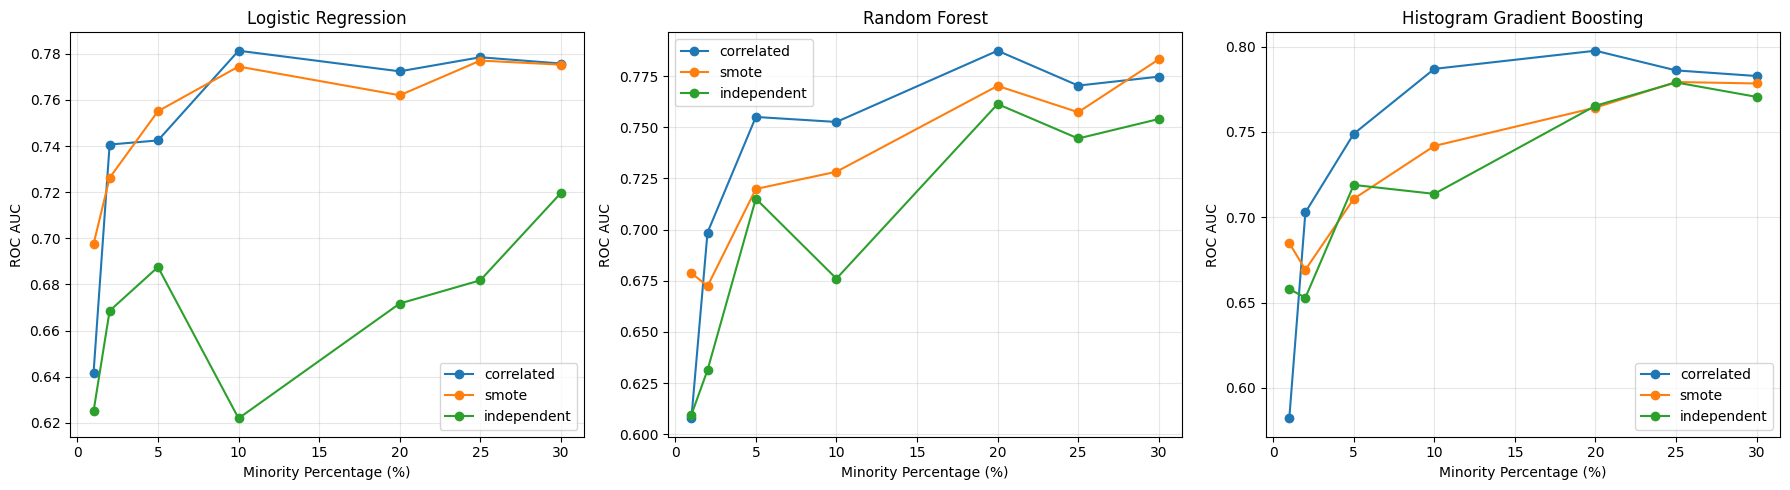

In [13]:
import re
import matplotlib.pyplot as plt

# Organize data by method and model type
data_by_model = {
    'logistic': {},
    'random_forest': {},
    'hist_gradient': {}
}

for filename, test_results in results.items():
    if not test_results:
        continue
    
    # Extract method and percentage using regex
    # Pattern: data/fitness/{method}/minority_{percentage}pct...
    match = re.search(r'data/fitness/([^/]+)/minority_(\d+)pct', filename)
    
    if match:
        method = match.group(1)
        percentage = int(match.group(2))
        
        # For each model type, store results
        for model_name in ['logistic', 'random_forest', 'hist_gradient']:
            if method not in data_by_model[model_name]:
                data_by_model[model_name][method] = {'percentages': [], 'roc_aucs': []}
            
            test_roc = test_results[model_name]['test_roc']
            data_by_model[model_name][method]['percentages'].append(percentage)
            data_by_model[model_name][method]['roc_aucs'].append(test_roc)

# Sort each method's data by percentage for each model
for model_name in data_by_model:
    for method in data_by_model[model_name]:
        sorted_pairs = sorted(zip(
            data_by_model[model_name][method]['percentages'],
            data_by_model[model_name][method]['roc_aucs']
        ))
        data_by_model[model_name][method]['percentages'], \
        data_by_model[model_name][method]['roc_aucs'] = zip(*sorted_pairs)

# Create three separate plots
model_titles = {
    'logistic': 'Logistic Regression',
    'random_forest': 'Random Forest',
    'hist_gradient': 'Histogram Gradient Boosting'
}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (model_name, ax) in enumerate(zip(['logistic', 'random_forest', 'hist_gradient'], axes)):
    for method, data in data_by_model[model_name].items():
        ax.plot(data['percentages'], data['roc_aucs'], marker='o', label=method)
    
    ax.set_xlabel('Minority Percentage (%)')
    ax.set_ylabel('ROC AUC')
    ax.set_title(f'{model_titles[model_name]}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()